## Testing CivitAi LoRA model
**Project summary**

*   Utilized CivitAI LoRA model - Realistic Vision V6.0 B1 based on SD 1.5 to generate images. Link: https://civitai.com/models/4201?modelVersionId=501240
*   Applied the LoRA weights from the "Realistic Vision" model to the unet component of the pipeline.
*  Customn dataset has 300+ images

**Future Plans for model improvement**

*  We are required to significantly increase the size and diversity of our dataset by collecting more cap images
*  Is is required to experiment with various hyperparameters and prompt input to increase accuracy of the output


In [ ]:
!pip install safetensors


In [ ]:
!pip install torch diffusers transformers


In [5]:
import zipfile
import os
#we unzip our folder containing 300+ basic images of caps

zip_file_path = "/content/Image_data.zip"
extraction_path = "/content/cap_images"
os.makedirs(extraction_path, exist_ok=True)


with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

In [2]:
from diffusers import StableDiffusionPipeline

# Loadding the base Stable Diffusion model
pipeline = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
pipeline.to("cuda")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "CompVis/stable-diffusion-v1-4",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [6]:
import torch
from safetensors.torch import load_file

# Loading LoRA weights for fine-tuning
lora_weights = load_file("/content/realisticVisionV60B1_v51HyperVAE.safetensors")

# Function to apply LoRA weights to the pipeline components
def apply_lora_weights(pipeline, lora_weights):
    for name, param in pipeline.unet.named_parameters():
        if name in lora_weights:
            param.data += lora_weights[name].data

apply_lora_weights(pipeline, lora_weights)


In [7]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os

class CapsDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = os.listdir(data_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Define transformations for the image to dimension 256*256
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Running the train component
train_dataset = CapsDataset("/content/cap_images", transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)


In [8]:
# Generate a single image
generated_images = pipeline("A cap with a colorful design").images

first_image = generated_images[0]



  0%|          | 0/50 [00:00<?, ?it/s]

In [26]:
#Generate a five image
prompt = (
    "A high-quality photo of a cap with a blue jeans-colored front panel. "
    "The crown features a perfectly clear and undistorted logo of 'ADIDAS' in white letters. "
)

num_images = 5
generated_images = [pipeline(prompt).images[0] for _ in range(num_images)]



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

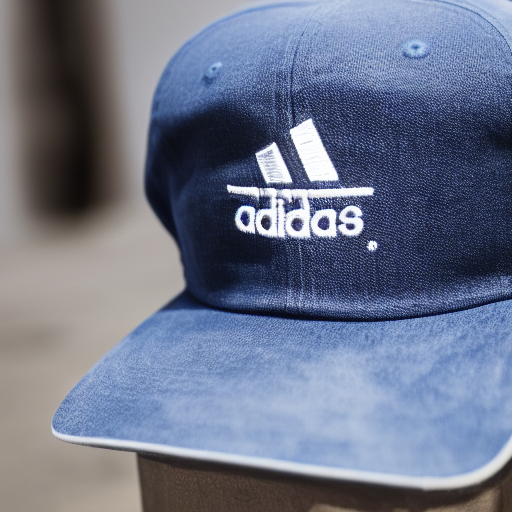

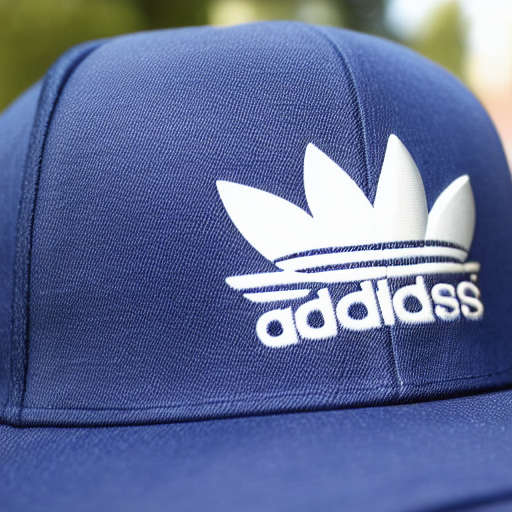

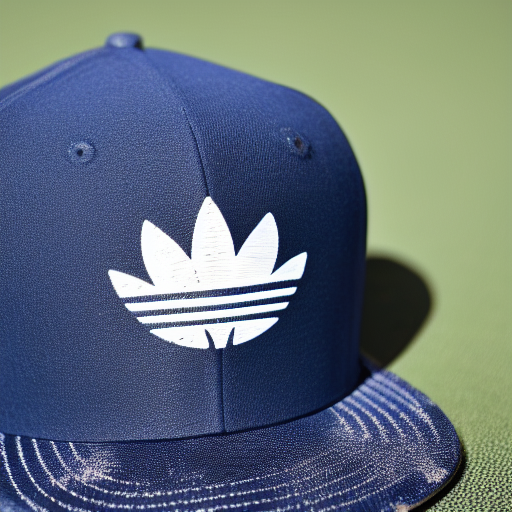

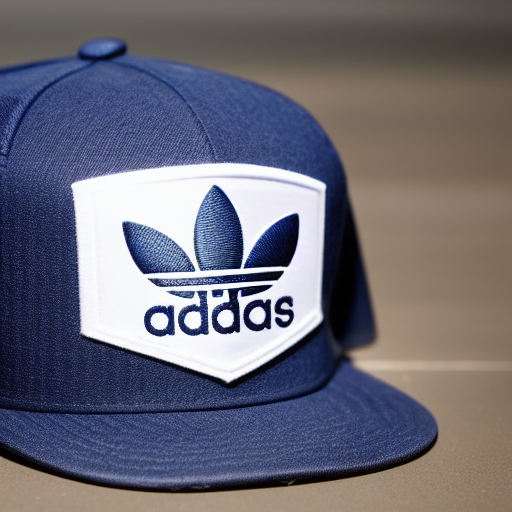

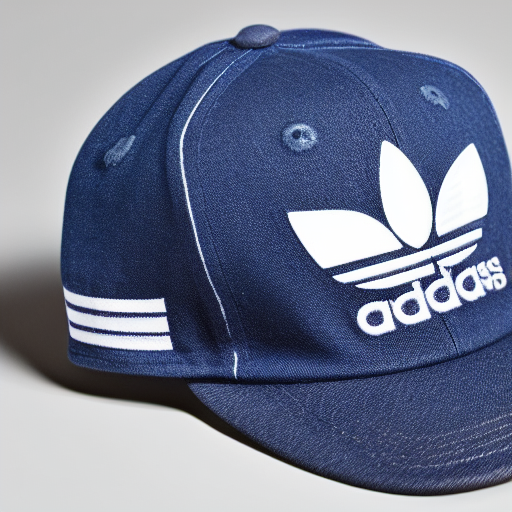

In [28]:
for img in generated_images:
    display(img)

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['.']


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['.']


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['.']


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['.']


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['.']


  0%|          | 0/50 [00:00<?, ?it/s]

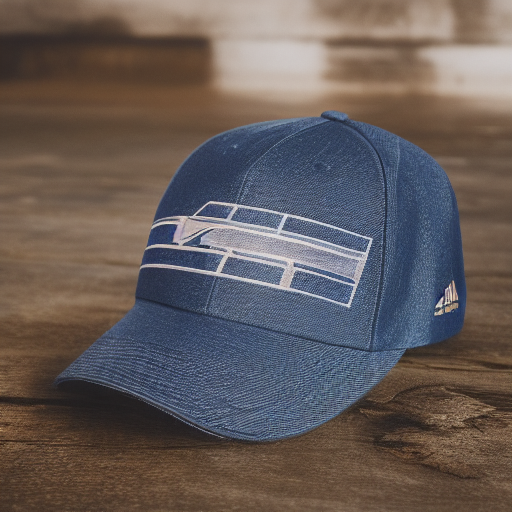

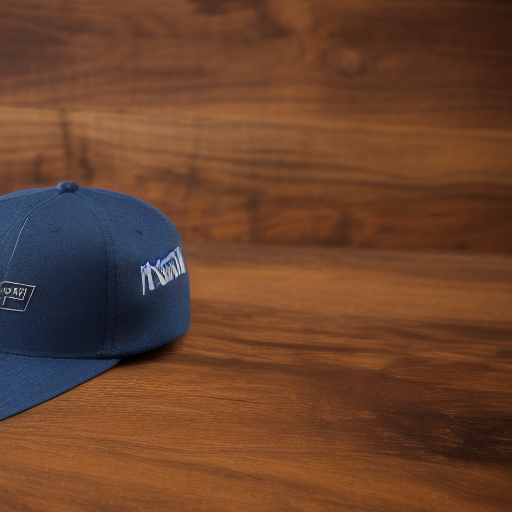

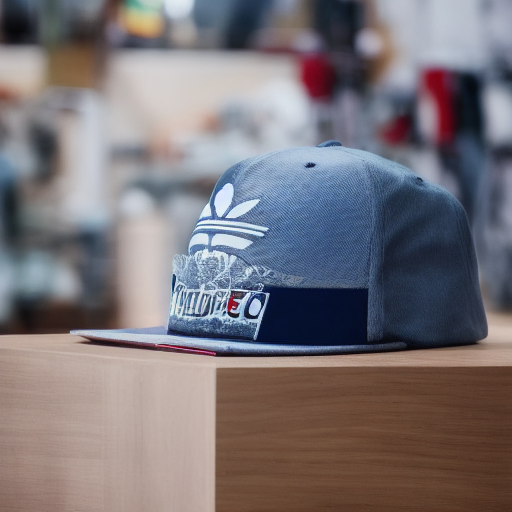

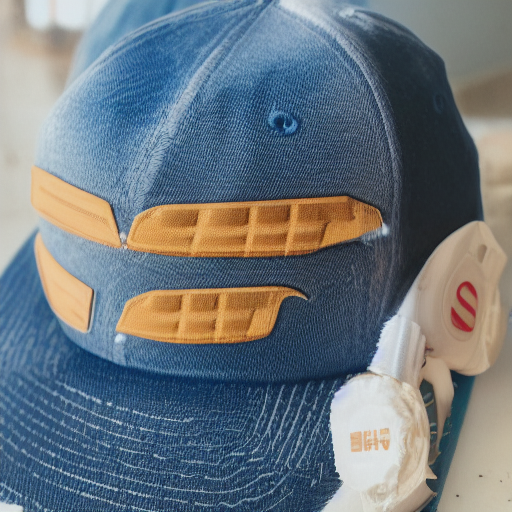

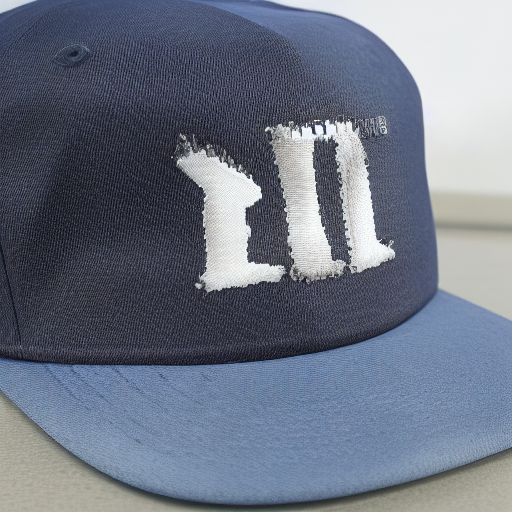

In [29]:
from diffusers import DDPMScheduler
from PIL import Image
from IPython.display import display

# Replacing with a compatible scheduler and setting the CFG scale
pipeline.scheduler = DDPMScheduler.from_config(pipeline.scheduler.config)

cfg_scale = 2.0

# Define the positive and negative prompts
positive_prompt = (
    "RAW photo of a custom Adidas cap with a blue jeans-colored front panel, 8k uhd, dslr, soft lighting, high quality, film grain, Fujifilm XT3. The crown features a perfectly clear and undistorted logo of 'ADIDAS' in white letters. There are three white stripes on the front panel, with a unique geometric pattern incorporated into the design."


)

negative_prompt = (
    "deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime, text, cropped, out of frame, "
    "worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers, mutated hands, poorly drawn hands, "
    "poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, "
    "malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck, UnrealisticDream, "
    "mutated hands and fingers:1.4, deformed, distorted, disfigured:1.3, poorly drawn, bad anatomy, wrong anatomy, extra limb, missing limb, floating limbs, "
    "disconnected limbs, mutation, mutated, ugly, disgusting, amputation, UnrealisticDream"
)

# Generate multiple images with positive and negative prompts
def generate_images(pipeline, positive_prompt, negative_prompt, num_images=5, cfg_scale=1.7):
    try:
        generated_images = [pipeline(positive_prompt, guidance_scale=cfg_scale, negative_prompt=negative_prompt).images[0] for _ in range(num_images)]
        for img in generated_images:
            display(img)
    except Exception as e:
        print(f"An error occurred: {e}")

# Generate and display the images
generate_images(pipeline, positive_prompt, negative_prompt, num_images=5, cfg_scale=cfg_scale)
